# Clustering Genomic Data

In this case study we accept data from a genome and have the goal of identifying useful genes versus noise. Unfortunately, we don't know which sequences of genes are useful, so we hvae to use unsupervised methods to infer this. 

In this notebook we walk through the following series of steps:

  1. Data is imported and prepared.  Initially the sequence, a single string, is split into non-overlapping substrings of length 300, and then counts the combinations of the distrinct 1, 2, 3, and 4-length sequences of base pairs which appear in each substring are made.
  2. PCA is performed to try to identify the internal structure of the data.
  3. Finally, if PCA reveals some internal structure then we'll apply clustering to it.

In [15]:
import pandas as pd
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

### The Data Preparation

The data prep was done fairly easily using regex to break up the strings into the components.

In [2]:
with open('data/ccrescentus.fa') as file:
    data = file.readlines()
    cleanarray = [string.replace('\n', '') for string in data[1:]]
    cleanstring = ''.join(cleanarray)

In [3]:
import re
arrays = re.findall('.{300}', cleanstring)
arrays

tbls = []
for wordlen in range(1, 5):
    counts = []
    for array in tqdm(arrays):
        worddict = {}
        for word in re.findall(''.join(['.{', str(wordlen), '}']), array):
            worddict[word] = worddict.get(word, 0) + 1
        counts.append(worddict)
    tbls.append(pd.DataFrame(counts))

100%|███████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 12601.34it/s]


### Principal Component Analysis

One reason why we try multiple word lengths is because without additional domain knowlecge it isn't clear if there are more meaningful units we could work with than individual letters.  So we calculate frequency tables to see if certain combinations happen more frequently (and more frequently together), and thus might be meaningful, than others. PCA helps us by creating natural clusters where combinations frequently co-occur and in reducing the dimension also enables us a unique way to visualize our dataset in a way that's otherwise not possible.

In [4]:
components = PCA(n_components=2)
components.fit(tbls[0])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

PCA Words of length: 1


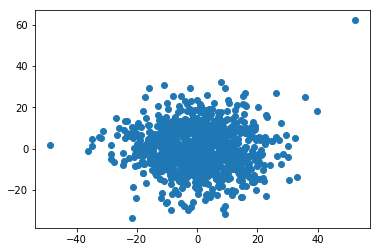

PCA Words of length: 2


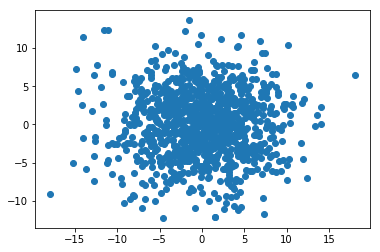

PCA Words of length: 3


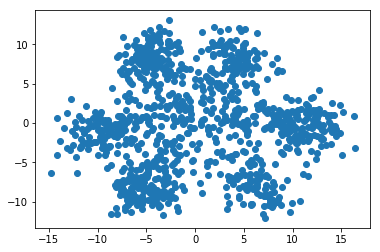

PCA Words of length: 4


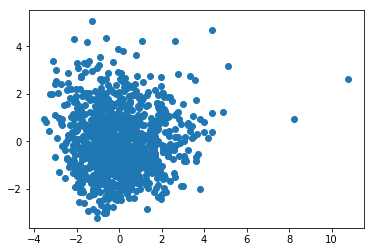

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

tbls_pca = []
for i in range(4):
    print(f"PCA Words of length: {i+1}")
    t = tbls[i].fillna(0)
    components = PCA(n_components=2)
    df = pd.DataFrame(components.fit_transform(t))
    tbls_pca.append(df)
    plt.scatter(df[0], df[1])
    plt.show()

### Clustering
In the cases of words of length 1, 2, and 4 there appears to only be one cluster, so k-means isn't going to yield anything interesting.  However, words of length 3 clearly appear to exhibit some clustering behavior.  It turns out that this is related to the transpositions of valid codons, but at the moment it isn't necessary to actually know that.  However, being able to understand the difference between clusters will end up being very useful in determining which three-base-pair sequences are valid code, so let's cluster!

In [19]:
triplets = tbls_pca[2]
model = KMeans(n_clusters = 7)
model.fit(triplets)

predictions = model.predict(triplets)

### Results in a Pretty Graph
Using our clustering results, we can visualizing the different colors!

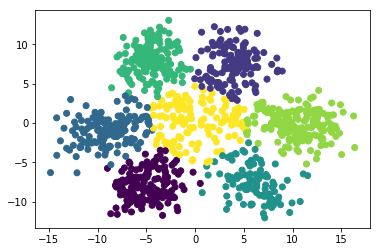

In [22]:
plt.scatter(triplets[0], triplets[1], c=predictions)
plt.show()

## Interesting Follow Ups

There are many follow up questions that one can ask with the data including:
  * What is the meaning of each cluster?
  * What the information content of each cluster?
  * Pricisely identify the start and end of genes (a little additional information required)